In [62]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/creditcard.csv.zip


In [63]:
import tensorflow as tf 
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)

filepath = './data/creditcard.csv.zip'

In [64]:
df = pd.read_csv(filepath)
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [65]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [66]:
%matplotlib inline
def plot(X,y,name="Scatter.png"):
    
    assert X.shape[0] == y.shape[0], "Expecting numer of instances of X, y to be same"
    
    tsne = TSNE(n_components=2,random_state=1)
    results = tsne.fit_transform(X)
    
    plt.figure(figsize=(16,10))
    
    is_non_fraud = np.where(y == 0)
    is_fraud = np.where(y==1)
    
    plt.scatter(results[is_non_fraud,0],results[is_non_fraud,1],color='g', label='Non Fraudulent Txn')
    plt.scatter(results[is_fraud,0],results[is_fraud,1],color='r', label='Fraudulent Txn')
    
    plt.legend()
    
    plt.show()

In [67]:
labels = df.pop('Class').values
txn_data = df.values

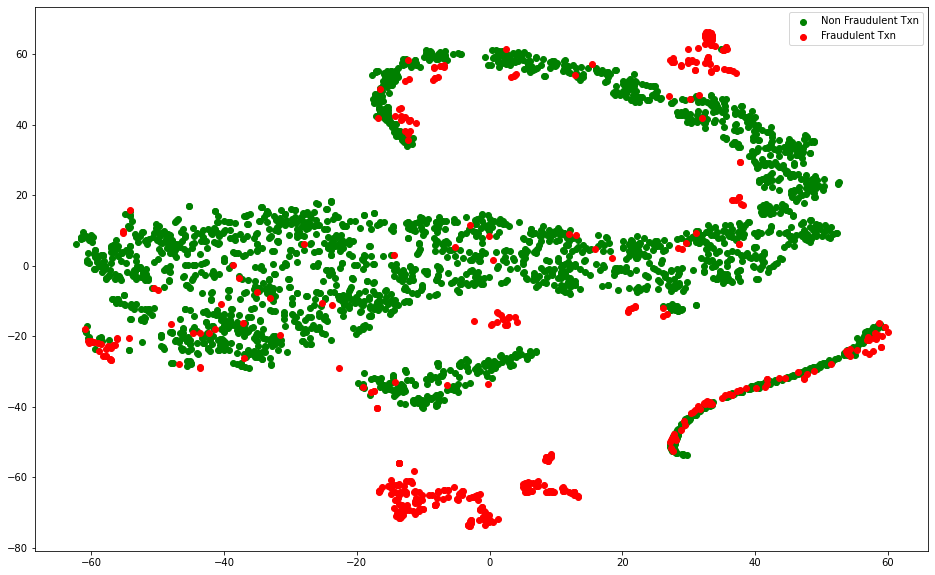

In [68]:
non_fraud_txn_data = txn_data[~labels.astype(bool)]
fraud_txn_data = txn_data[labels.astype(bool)]

sample_non_fraud = non_fraud_txn_data[np.random.randint(len(non_fraud_txn_data),size=2500)]

X = np.concatenate((sample_non_fraud,fraud_txn_data))

y = np.concatenate((np.zeros(len(sample_non_fraud)),np.ones(len(fraud_txn_data))))

plot(X,y)

In [69]:
txn_data = tf.keras.utils.normalize(txn_data,axis=-1, order=2)
non_fraud_txn_data = txn_data[~labels.astype(bool)]
fraud_txn_data = txn_data[labels.astype(bool)]

In [70]:
from sklearn.model_selection import train_test_split
labels = labels.astype(int)
tain_data,test_data,train_labels,test_labels = train_test_split(txn_data,labels,test_size=0.25, random_state=42)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
clf = LogisticRegression(random_state=0).fit(tain_data, train_labels)
y_pred = clf.predict(test_data)

y_pred = clf.predict(fraud_txn_data)
accuracy_score(np.ones(len(y_pred)),y_pred)


0.4166666666666667

### AutoEncoder ###

In [72]:
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

class AutoEncoder(tf.keras.Model):
    def __init__(self,input_dim):
        super(AutoEncoder,self).__init__()
        self.encoder = Sequential([
            Dense(256,activation='relu',activity_regularizer=regularizers.l1(10e-5)),
            Dense(128,activation='relu')
        ])
        
        self.decoder = Sequential([
            Dense(128,activation='relu'),
            Dense(256,activation='relu'),
            Dense(input_dim,activation='sigmoid')
        ])
    def call(self,inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [73]:
_, input_dim = txn_data.shape

autoencoder = AutoEncoder(input_dim)

In [74]:
autoencoder.compile(optimizer='adadelta', loss='mae', metrics=None)

In [75]:
history = autoencoder.fit(non_fraud_txn_data[:2000], non_fraud_txn_data[:2000], 
          epochs=15, 
          batch_size=512,
          validation_data=(test_data,test_data),
          shuffle=True)

Epoch 1/15
4/4 [==============================] - 1s 142ms/step - loss: 0.4904 - val_loss: 0.4877
Epoch 2/15
4/4 [==============================] - 0s 132ms/step - loss: 0.4903 - val_loss: 0.4877
Epoch 3/15
4/4 [==============================] - 0s 125ms/step - loss: 0.4905 - val_loss: 0.4877
Epoch 4/15
4/4 [==============================] - 0s 123ms/step - loss: 0.4905 - val_loss: 0.4877
Epoch 5/15
4/4 [==============================] - 0s 130ms/step - loss: 0.4904 - val_loss: 0.4877
Epoch 6/15
4/4 [==============================] - 0s 138ms/step - loss: 0.4905 - val_loss: 0.4877
Epoch 7/15
4/4 [==============================] - 0s 128ms/step - loss: 0.4902 - val_loss: 0.4877
Epoch 8/15
4/4 [==============================] - 0s 132ms/step - loss: 0.4904 - val_loss: 0.4877
Epoch 9/15
4/4 [==============================] - 0s 128ms/step - loss: 0.4902 - val_loss: 0.4877
Epoch 10/15
4/4 [==============================] - 0s 128ms/step - loss: 0.4903 - val_loss: 0.4877
Epoch 11/15
4/4 [==

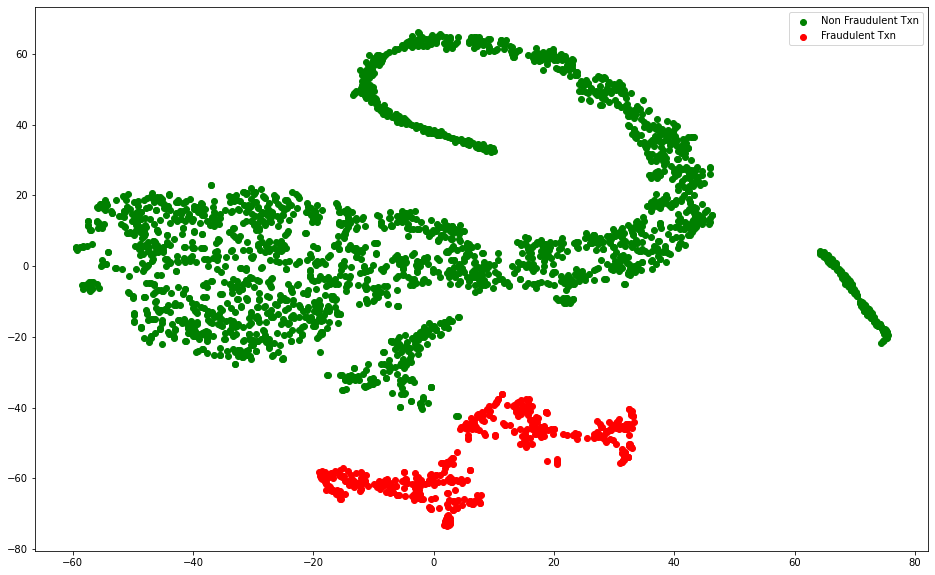

In [76]:
encoded_sample = autoencoder.encoder(sample_non_fraud).numpy()
encoded_fraud = autoencoder.encoder(fraud_txn_data).numpy()

X = np.concatenate((encoded_sample,encoded_fraud))

y = np.concatenate((np.zeros(len(sample_non_fraud)),np.ones(len(fraud_txn_data))))

plot(X,y)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

train_data_encoded = autoencoder.encoder(tain_data)

clf = LogisticRegression(random_state=0).fit(train_data_encoded, train_labels)

test_data_encoded = autoencoder.encoder(fraud_txn_data)
y_pred = clf.predict(test_data_encoded)
accuracy_score(np.ones(len(fraud_txn_data)),y_pred)

0.2703252032520325

In [98]:
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

class AnomalyDetector(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = autoencoder.encoder
        self.fc1 = Dense(256,activation='relu')
        self.fc2 = Dense(128,activation='relu')
        self.fc4 = Dense(64,activation='relu')
        self.fc3 = Dense(1,activation='sigmoid')
    def call(self,inputs):
        encoded = self.encoder(inputs)
        x = self.fc1(encoded)
        x = self.fc2(x)
        x = self.fc4(x)
        probs = self.fc3(x)
        return probs

In [99]:
anomaly_detector = AnomalyDetector()
anomaly_detector.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])


In [100]:
history = anomaly_detector.fit(tain_data, train_labels,
          epochs=5, 
          batch_size=512,
          validation_split=.15,
          shuffle=True)

Epoch 1/5
355/355 [==============================] - 3s 7ms/step - loss: 0.0707 - accuracy: 0.9812 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 2/5
355/355 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 3/5
355/355 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0033 - val_accuracy: 0.9995
Epoch 4/5
355/355 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0032 - val_accuracy: 0.9995
Epoch 5/5
355/355 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0035 - val_accuracy: 0.9993


In [101]:
_, fraud_acc = anomaly_detector.evaluate(fraud_txn_data,np.ones(len(fraud_txn_data)))
_, total_acc =  anomaly_detector.evaluate(test_data,test_labels)

2226/2226 [==============================] - 4s 2ms/step - loss: 0.0040 - accuracy: 0.9992
